In [33]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
import numpy as np

import zipfile
import pickle 
import sys
import re
import string
import math 
import random 
import time
import preprocessor as p


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter


from wordcloud import WordCloud, STOPWORDS

from scipy import spatial

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import files
uploaded = files.upload()


Saving negative_tweets.txt to negative_tweets (1).txt
Saving positive_tweets.txt to positive_tweets (1).txt
Saving tweets.txt to tweets (2).txt


In [3]:
tweets = "tweets.txt"
uploaded[tweets].decode("utf-8")
tweets_data = uploaded[tweets].decode("utf-8").split("\r\n")

In [16]:
#Helpful functions
def get_transcript_lines(x):
    import pandas  as pd
    if pd.isnull(x): return []
    x = filter(lambda x: (':' not in x) or not (x[0:x.find(':')].isdigit() and  x[x.find(':')+1:].isdigit()) , # remove time HH:MM
            filter(lambda x: not (x.startswith('(') and x.endswith(')')) , map(str.strip, x.split('\n\n\n'))))        
    return list(x)

def preprocess_line(line): 
    line = p.clean(line)
    line = line.strip("RT")
    line = re.sub(r"http\S+", "",line)
    line = line.translate(str.maketrans('','', string.punctuation))
    line = line.lower()
    line = re.sub("'", "", line)
    line = re.sub("@[A-Za-z0-9_]+","", line)
    line = re.sub("#[A-Za-z0-9_]+","", line)
    line = re.sub('[()!?]', ' ', line)
    line = re.sub('\[.*?\]',' ', line)
    line = re.sub("[^a-z0-9]"," ", line)       
    return line.strip().lower().translate(str.maketrans('', '', string.punctuation)).replace('\n', ' ')

def isalpha_func(txt):
  text = []
  [text.append(x) for x in txt if x.isalpha]
  return text
  
def lemmatizing(txt):
  text = []
  lemmatizer = WordNetLemmatizer()
  [text.append(lemmatizer.lemmatize(x)) for x in txt]
  return text

def stop_w(txt):
  stop_words = set(stopwords.words('english'))
  text = []
  [text.append(x) for x in txt if x not in stop_words]
  return text

def count_words(words):
  from collections import Counter
  counts = Counter(words) 
  v = list()
  for i,w in enumerate(counts):
      print(f"{i}. {w} – {counts[w]}")   
      v.append(counts[w])
  return v

rt_remove = lambda x: re.compile('\#').sub('', re.compile('RT @').sub('@', x, count=1).strip())
url_remove = lambda x: re.sub(r"http\S+", "", x)
username_remove = lambda x: re.sub('@[\s]+','',x)

def build_dictionary(text_file, word_lst):
    vocab = dict()    
    number_of_documents = 0
    for line in text_file: 
      for word in line: # add words into dictionary. 
        if word not in vocab:
          if word in word_lst: 
            vocab[word] = len(vocab) # add word to vocab with a new index                    
      number_of_documents += 1
    # inverse dictionary: retrieve word by its ID. 
    inverse_vocab = dict([(value, key) for key, value in vocab.items()])
    return vocab, inverse_vocab, number_of_documents

def word_frequency(corpus):
  corp = []
  for x in corpus:
    corp += x 
  count = Counter(corp)
  return count

#Term frequency
def tf_calculator(list_of_words, word):
  word_count = list_of_words.count(word)
  if len(list_of_words) == 0:
        return 0
  return word_count/len(list_of_words)

# def idf_calculator(corpus, document_frequency, word_idx):
#     num_of_doc_freq_of_word = document_frequency[word_idx]
#     return np.log(len(corpus)/num_of_doc_freq_of_word)



# def tf_calculator(line, word):
#     # The function calculates and returns the term frequency
#     total = len(line.split())
#     appearances = line.lower().split().count(word)
#     if total == 0:
#         return 0
#     else:
#         return appearances/total


# Inverse document frequency
def idf_calculator(corpus, value):
    return np.log(len(corpus)/value)  

In [17]:
def preprocessing(corpus):
  corpus = [username_remove(x) for x in corpus]
  
  corpus = [preprocess_line(line) for line in corpus]

  corpus = [word_tokenize(x) for x in corpus] #Word tokenizing - seperating each sentence to a list of words.

  corpus = [lemmatizing(x) for x in corpus] #Uniting together words with similar meaninings

  corpus = [stop_w(x) for x in corpus] #Removing non-informative words using the stopwords command

  return corpus

**Question 1**

In [18]:
def tfidf_vectorizer(corpus, min_word_freq):

  corpus = preprocessing(corpus)

  dict_freq = word_frequency(corpus)
  words_above = [x for x in dict_freq.items() if x[1] > min_word_freq]
  words_above = dict(words_above)
  vocab, inverse_vocab, N = build_dictionary(corpus, words_above)

# document frequency 
  doc_freq_vec = [] 
  for x in vocab:
    counter = 0 
    for line in corpus:
      if x in line:
        counter += 1
    doc_freq_vec.append(counter)
  doc_freq_vec = np.array(doc_freq_vec)

  corpus = [" ".join(item) for item in corpus] # Joining back all the words to a single string for each row.

# word frequency
  word_freq_vector = []
  for word in vocab:
    word_freq_vector.append(words_above.get(word))
  word_freq_vector = np.array(word_freq_vector)

# matrix of shape len(documents) x len(vocab) with TF-IDF values for every document in the corpus.
  matrix_tf_idf = [[0 for x in range(len(vocab))] for y in range(len(corpus))]
  for line in corpus:
    i = corpus.index(line)
    j = 0
    for word in vocab:
      matrix_tf_idf[i][j] = tf_calculator(line,word)*idf_calculator(corpus, doc_freq_vec[vocab[word]])
      j += 1

  df = pd.DataFrame(matrix_tf_idf, columns=vocab)

  return vocab, doc_freq_vec, word_freq_vector, df

In [19]:
# testing our function on the tweets data. Running time
voc, vec, freq, mat  = tfidf_vectorizer(tweets_data, 5)

In [20]:
voc

{'cost': 0,
 'uk': 1,
 'eu': 2,
 'britain': 3,
 'billion': 4,
 'per': 5,
 'year': 6,
 'video': 7,
 'sturgeon': 8,
 'postelection': 9,
 'deal': 10,
 'economy': 11,
 'wa': 12,
 'growing': 13,
 'time': 14,
 'faster': 15,
 'day': 16,
 'david': 17,
 'cameron': 18,
 'became': 19,
 'prime': 20,
 'minister': 21,
 'today': 22,
 'ukip': 23,
 'east': 24,
 'candidate': 25,
 'look': 26,
 'still': 27,
 'ha': 28,
 'ukips': 29,
 'housing': 30,
 'spokesman': 31,
 'rake': 32,
 'k': 33,
 'benefit': 34,
 'migrant': 35,
 'make': 36,
 'sure': 37,
 'tune': 38,
 'tonight': 39,
 'bbc': 40,
 '50': 41,
 'ed': 42,
 'milliband': 43,
 'embarrassment': 44,
 'would': 45,
 'want': 46,
 'vote': 47,
 'ft': 48,
 'backing': 49,
 'tory': 50,
 'unrelated': 51,
 'note': 52,
 'photo': 53,
 'leader': 54,
 'writer': 55,
 'jonathan': 56,
 'ford': 57,
 'next': 58,
 'boris': 59,
 'miliband': 60,
 'proved': 61,
 'job': 62,
 'youve': 63,
 'spent': 64,
 'trickle': 65,
 'wealth': 66,
 'never': 67,
 'past': 68,
 'always': 69,
 'win': 7

In [21]:
vec

array([ 54, 514, 308, ...,   6,   6,   7])

In [22]:
freq

array([ 54, 534, 332, ...,  12,   6,   7])

In [23]:
mat.head(5)

,cost,uk,eu,britain,billion,per,year,video,sturgeon,postelection,deal,economy,wa,growing,time,faster,day,david,cameron,became,prime,minister,today,ukip,east,candidate,look,still,ha,ukips,housing,spokesman,rake,k,benefit,migrant,make,sure,tune,tonight,...,walked,fixated,valiant,bridge,cowardampa,merciless,quentin,letts,informed,sido,muy,claro,mustard,fingered,rank,ice,overtime,scotswe,bongo,excelle,excessive,conveniently,beeped,tactical,hyp,aampe,safely,ton,labourtories,opposes,budge,signatory,toriestelegraph,plaidsnp,legislate,eitherhe,inwhat,alienating,unsuccessful,awe
0,0.198307,0.062811,0.071071,0.076571,0.107097,0.119814,0.065503,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093017,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152796,0.117975,0.196449,0.090473,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.06893,0.039997,0.091559,0.038652,0.093316,0.13024,0.035823,0.031297,0.086976,0.066679,0.067099,0.06974,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.077886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.054779,0.156678,0.097373,0.08787,0.095317,0.063147,0.000000,0.000000,0.000000,0.000000,0.230682,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.072116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.050721,0.000000,0.000000,0.00000,0.000000,0.000000,0.104383,0.254756,0.137564,0.147024,0.427189,0.077087,0.116414,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question 2**

Building a "search" function based on previous implementations.

In [26]:
def search(vocab, doc_freq_vec, word_freq_vector, matrix, list_of_tweets, search_query, num_of_matches):

  search_query = [search_query, search_query]
  preprocessed_query = preprocessing(search_query)
  preprocessed_list = preprocessing(list_of_tweets)
  query_tf_idf = []
    
  for word in vocab.keys():
      if word in preprocessed_query[0]:
        tf_idf = tf_calculator(preprocessed_query[0], word)*idf_calculator(preprocessed_list, doc_freq_vec[vocab[word]])
      else:
        tf_idf = 0
      query_tf_idf.append(tf_idf)
  query_tf_idf  = [query_tf_idf]

  similarities = cosine_similarity(matrix,query_tf_idf).flatten() 
  similarity_rank = (-similarities).argsort().flatten()[:num_of_matches] # rank all topics by their similarity to the query. 

  tweets_ranked, values_fit = [], []
  for idx, val in enumerate(similarity_rank):
      tweets_ranked.append(list_of_tweets[val])
      values_fit.append(similarities[val])
        
  return tweets_ranked, values_fit

$CosineSimilarity(X,Y) = \frac{ \sum{x_i}{y_i}} { \sqrt(\sum(x_i^2)\times\sqrt(\sum(y_i^2)}$

Implementing the search function and presenting a few examples of using the search engine. We will use the output of the test from before. Furthemore, we will generate a random tweet to the search query. 

In [38]:
#First example

search_query = tweets_data[random.randint(0,len(tweets_data))]

tweets_ranked, values_fit = search(voc, vec, freq, mat, tweets_data, search_query, num_of_matches = 3)

results_df = pd.DataFrame(list(zip(tweets_ranked, values_fit)), columns =['tweet', 'fit_value'])

print(f'The generated first example for the search query is: {search_query}')
results_df

The generated first example for the search query is: RT @LabourEoin: David Cameron keeps rabbiting on about UK growth. May I show you the actual UK growth figures? #BBCqt http://t.co/wqGfvWXHWy


,tweet,fit_value
0,RT @LabourEoin: David Cameron keeps rabbiting ...,0.290523
1,What actually are ukip,0.132556
2,RT @SuPr3m3B3iNG1: @Nigel_Farage @UKIP UKIP @N...,0.125058


In [123]:
#Second example

search_query = tweets_data[random.randint(0,len(tweets_data))]

tweets_ranked, values_fit = search(voc, vec, freq, mat, tweets_data, search_query, num_of_matches = 3)

results_df = pd.DataFrame(list(zip(tweets_ranked, values_fit)), columns =['tweet', 'fit_value'])

print(f'The generated second example for the search query is: {search_query}')
results_df

The generated second example for the search query is: #shyster 


,tweet,fit_value
0,#shyster,0.430309
1,Perfectly summed up @Bonn1eGreer #shyster #GE2...,0.092747
2,They've made Cam look like the shyster he is; ...,0.074015


In [132]:
#Third example - now using a specific sentence

search_query = "He had a way with women"

tweets_ranked, values_fit = search(voc, vec, freq, mat, tweets_data, search_query, num_of_matches = 5)

results_df = pd.DataFrame(list(zip(tweets_ranked, values_fit)), columns =['tweet', 'fit_value'])

print(f'The generated third example for the search query is: {search_query}')
results_df

The generated third example for the search query is: He had a way with women


,tweet,fit_value
0,He had a way with women,0.512053
1,@Broughy90 I feel like we need a woman again. ...,0.196580
2,"Nicola Sturgeon, what a woman 💙💙",0.142915
3,Love Nicola sturgeon what a woman,0.124507
4,http://t.co/0XhM2gKvVO via @MailOnline - STOP...,0.122205


As we can see, the search function works good and managed to find the relevant tweets as the tweets with the highest values. Although, we expected higher values for the right answer. The reason the fitted value for the correct answer is lower than our expectations is due to our harsh preprocessing (which is crutial due to the amount of non relevant items in each tweet).  

**Question 3**

In [32]:
# tic and toc functions for measuring time 
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc(pName=''):
    if 'startTime_for_tictoc' in globals():
        delta = time.time() - startTime_for_tictoc
        print("{}: Elapsed time is ".format(pName) + str(int(delta)) + " seconds, or " + str(round(delta/60,2))+ " minutes")
    else:
        delta = -1
        print("Toc: start time not set") 
    return delta

Performance comparison between our function "tfidf_vectorizer" to sklearn
implementation. We would use tic and toc functions. 

In [34]:
preprocessed_tweets = preprocessing(tweets_data)
preprocessed_tweets = [" ".join(item) for item in preprocessed_tweets] # Joining back all the words to a single string for each row.

In [35]:
def tfidf_sk(corpus, min_word_freq):
  vectorizer = TfidfVectorizer(min_df = min_word_freq)
  response = vectorizer.fit_transform(corpus)
  sk_df = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
  return sk_df

In [36]:
tic()
tfidf_sk(preprocessed_tweets, 5)
print("The running time for this method is", round(toc(),3), "seconds")


: Elapsed time is 0 seconds, or 0.01 minutes
The running time for this method is 0.423 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
tic()
tfidf_vectorizer_check  = tfidf_vectorizer(tweets_data, 5)
print("The running time for this method is", round(toc(),3), "seconds")

: Elapsed time is 337 seconds, or 5.63 minutes
The running time for this method is 337.519 seconds


First of all, our function (with minimal word frequency of 5) found a bit fewer words than the sklearn approach(4243 words). Furthemore, the sklearn's running time is way more efficient than the function created in question 1. While the running time of the sklearn tfidf_vectorizer takes less than a second, our tfidf_vectorizer approach takes a couple of minutes. 


**Memory requirments**

 How much RAM is consumed to store results for each of the approaches?


In [40]:
sk_df = tfidf_sk(preprocessed_tweets, 5)
print("sklearn tfidf:", sys.getsizeof(sk_df))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sklearn tfidf: 664527520


In [41]:
print("tfidf matrix:", sys.getsizeof(tfidf_vectorizer_check))

tfidf matrix: 88


In [42]:
%load_ext memory_profiler
from memory_profiler import profile

In [44]:
# Memory - tfidf_sklearn:
%memit tfidf_sk(tweets_data, 5)

peak memory: 5384.78 MiB, increment: 0.38 MiB


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
# Memory - tfidf_vectorizer:
%memit tfidf_vectorizer(tweets_data, 5)

peak memory: 6191.34 MiB, increment: 806.56 MiB


**Question 4**

In [46]:
negative_tweets = "negative_tweets.txt"
positive_tweets = "positive_tweets.txt"

uploaded[negative_tweets].decode("utf-8")
negative_tweets_data = uploaded[negative_tweets].decode("utf-8").split("\r\n")

uploaded[positive_tweets].decode("utf-8")
positive_tweets_data = uploaded[positive_tweets].decode("utf-8").split("\r\n")

In [47]:
!pip install wordcloud

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [49]:
def preprocess_and_unite_text(corpus):
    # Pre process
    stopwords_list=set(stopwords.words('english'))    
    _clean_tweets_list=[]
    for tweet in corpus:
        clean_single_tweet_list=[]
        for word in tweet.split():
            if word.startswith(("RT","rt","@","#","http")) or word in stopwords_list:
                pass
            else: 
                clean_word = word.translate(str.maketrans('', '', string.punctuation)).lower()
                clean_single_tweet_list.append(clean_word)
        clean_signal_tweet_str=' '.join(clean_single_tweet_list)
        _clean_tweets_list.append(clean_signal_tweet_str)
    
    text=(" ").join(_clean_tweets_list)
    
    return text

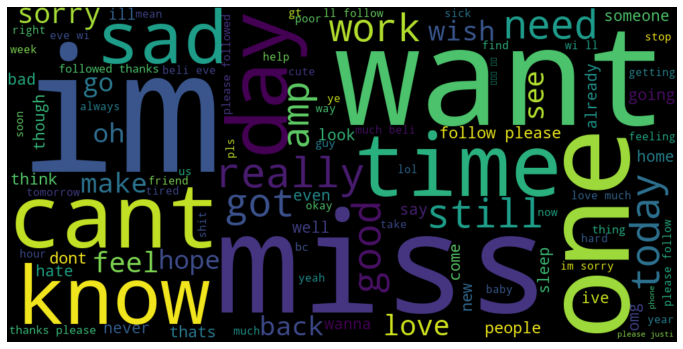

In [50]:
processed_negative = preprocess_and_unite_text(negative_tweets_data)

wordcloud = WordCloud(background_color="black", max_words=100,stopwords=STOPWORDS,max_font_size=256, random_state=42, width = 1000, height = 500).generate(processed_negative)
wordcloud = wordcloud.generate(processed_negative)

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
      


The figure shows the words which indicate the most negative tweets, the bigger the word the more it indicates negativity in tweets. This also indicates that these words have the highest values of tf-idf in aggregation from the negative tweets data. 

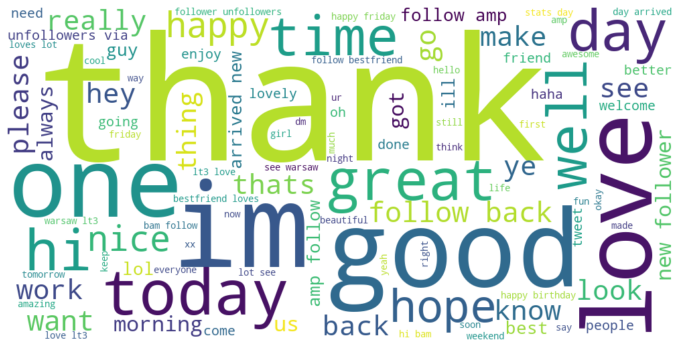

In [51]:
processed_positive = preprocess_and_unite_text(positive_tweets_data)

wordcloud = WordCloud(background_color="white", max_words=100,stopwords=STOPWORDS,max_font_size=256, random_state=42, width = 1000, height = 500).generate(processed_positive)
wordcloud = wordcloud.generate(processed_positive)

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
      

The figure shows the words which indicate the most positive tweets, the bigger the word the more it indicates positivity in tweets. This also indicates that these words have the highest values of tf-idf in aggregation from the positive tweets data. This also makes sense, a quick observation of the words implement words we tend to use in positive contexts.

In [52]:

neg_lst = []
neg_lst.append(processed_negative)

neg_vectorizer = TfidfVectorizer()
neg_fit = neg_vectorizer.fit_transform(neg_lst)
df_tfidf_neg = pd.DataFrame(neg_fit.toarray(),columns=neg_vectorizer.get_feature_names())

for col in df_tfidf_neg.columns:
    if col in STOPWORDS:
        del df_tfidf_neg[col]

res_neg = pd.DataFrame({n: df_tfidf_neg.T[col].nlargest(10).index.tolist() for n, col in enumerate(df_tfidf_neg.T)}, index=range(1,11))
temp = df_tfidf_neg.sum()
res_neg["val"] = [temp[word] for word in res_neg.iloc[0:10, 0]]
res_neg 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,val
1,im,0.395737
2,please,0.228536
3,miss,0.199969
4,cant,0.189886
5,want,0.183165
6,sorry,0.124350
7,one,0.120990
8,follow,0.119309
9,time,0.118469
10,much,0.116789


In [53]:
pos_lst = []
pos_lst.append(processed_positive)

pos_vectorizer = TfidfVectorizer()
pos_fit = pos_vectorizer.fit_transform(pos_lst)
df_tfidf_pos = pd.DataFrame(pos_fit.toarray(),columns=pos_vectorizer.get_feature_names())

for col in df_tfidf_pos.columns:
    if col in STOPWORDS:
        del df_tfidf_pos[col]

res_pos = pd.DataFrame({n: df_tfidf_pos.T[col].nlargest(10).index.tolist() for n, col in enumerate(df_tfidf_pos.T)}, index=range(1,11))
temp = df_tfidf_pos.sum()
res_pos["val"] = [temp[word] for word in res_pos.iloc[0:10, 0]]
res_pos 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,val
1,thanks,0.313513
2,follow,0.243133
3,love,0.216740
4,thank,0.196745
5,im,0.187948
6,good,0.186348
7,day,0.164754
8,happy,0.151958
9,great,0.137562
10,hi,0.137562


As we can see, the words with the highest score are the dominant words we can see in our WordCloud visualization above. 